In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# HSMMの性能比較の数値実験

In [3]:
import sys
sys.path.append("../lib")

In [4]:
import math

from IPython.core.display import display, Markdown, Latex
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import gammaln, psi
from scipy.stats import norm, t, cauchy, laplace, gumbel_r, gamma, skewnorm, pareto, multivariate_normal, kurtosis, skew
from typing import Callable
from sklearn.mixture import BayesianGaussianMixture
from sklearn.datasets import load_iris, load_wine, load_breast_cancer

from HyperbolicSecantMixtureModelVB import HyperbolicSecantMixtureVB
from learning import GaussianMixtureModelVB
from util import GaussianMixtureModel, HyperbolicSecantMixtureModel, StudentMixtureModel, LaplaceMixtureModel, GumbelMixtureModel

# 問題設定

## 真の分布の設定
+ データ生成分布は変更しますが、混合比, 中心, scaleは同じものを流用

In [5]:
true_ratio = np.array([0.33, 0.33, 0.34])
true_delta = 0
true_s = np.array([[2, 2], [0.5, 0.5], [1, 1]])
true_b = np.array([[2, 4], [-4, -2], [0, 0]])
true_param = dict()
true_param["ratio"] = true_ratio
true_param["mean"] = true_b
true_param["precision"] = true_s
true_param["scale"] = np.array([np.diag(1/np.sqrt(true_s[k,:])) for k in range(len(true_ratio))])
K0 = len(true_ratio)
M = true_b.shape[1]

## Learning setting:

In [6]:
### 学習データの数
n = 400

### テストデータの数
N = 10000

### データの出方の個数
ndataset = 50

### 事前分布のハイパーパラメータ
pri_params = {
    "pri_alpha": 0.1,
    "pri_beta": 0.001,
    "pri_gamma": M+2,
    "pri_delta": 1
}

### データ生成の回数
data_seed_start = 201907
data_seeds = np.arange(start = data_seed_start, stop = data_seed_start + ndataset, step = 1)

### 学習モデルの初期値の乱数 -> データseedにoffsetを加えたものを使う
learning_num = 10
learning_seed_offset = 100

### 繰り返しアルゴリズムの繰り返し回数
learning_iteration = 1000

### 学習モデルのコンポーネントの数
K = np.array([5, 3])

# 性能評価
+ 1連の流れ
    1. データ生成する
    1. 学習を行う
    1. 精度評価を行う
    1. 1に戻って再度計算

# コンポーネントの分布が正規分布の場合

In [7]:
gerror_gmm_diag = np.zeros(len(data_seeds))
cklerror_gmm_diag = np.zeros(len(data_seeds))
c01error_gmm_diag = np.zeros(len(data_seeds))

gerror_gmm_cov = np.zeros(len(data_seeds))
cklerror_gmm_cov = np.zeros(len(data_seeds))
c01error_gmm_cov = np.zeros(len(data_seeds))

gerror_hsmm = np.zeros(len(data_seeds))
cklerror_hsmm = np.zeros(len(data_seeds))
c01error_hsmm = np.zeros(len(data_seeds))

for i, data_seed in enumerate(data_seeds):
    ### データを生成する
    (train_X, train_label, train_label_arg) = GaussianMixtureModel.rvs(true_ratio, true_b, true_s, size = n, data_seed = data_seed)
    (test_X, test_label, test_label_arg) = GaussianMixtureModel.rvs(true_ratio, true_b, true_s, size = N)
    
    gmm_diag_obj = GaussianMixtureModelVB(K = K[0],
                                     pri_alpha = pri_params["pri_alpha"], pri_beta = pri_params["pri_beta"], pri_gamma = pri_params["pri_gamma"], pri_delta = pri_params["pri_delta"], 
                                     iteration = 1000, restart_num=learning_num, learning_seed=data_seed + learning_seed_offset, method = "diag")
    gmm_diag_obj.fit(train_X)
    
    gmm_cov_obj = GaussianMixtureModelVB(K = K[0],
                                     pri_alpha = pri_params["pri_alpha"], pri_beta = pri_params["pri_beta"], pri_gamma = pri_params["pri_gamma"], pri_delta = pri_params["pri_delta"], 
                                     iteration = 1000, restart_num=learning_num, learning_seed=data_seed + learning_seed_offset, method = "full")
    gmm_cov_obj.fit(train_X)
    
    hsmm_obj = HyperbolicSecantMixtureVB(K = K[0],                                     
                                         pri_alpha = pri_params["pri_alpha"], pri_beta = pri_params["pri_beta"], pri_gamma = pri_params["pri_gamma"], pri_delta = pri_params["pri_delta"], 
                                         iteration = 1000, restart_num=learning_num, learning_seed=data_seed + learning_seed_offset)
    hsmm_obj.fit(train_X)
    posterior_true_logprob = GaussianMixtureModel().latent_posterior_logprob(train_X, true_ratio, true_b, true_s)
    cklerror_gmm_diag[i] = gmm_diag_obj.score_latent_kl(posterior_true_logprob)[0]/len(train_X)
    cklerror_gmm_cov[i] = gmm_cov_obj.score_latent_kl(posterior_true_logprob)[0]/len(train_X)
    cklerror_hsmm[i] = hsmm_obj.score_latent_kl(posterior_true_logprob)[0]/len(train_X)
    
    c01error_gmm_diag[i] = gmm_diag_obj.score_clustering(train_label_arg)[0]/len(train_X)
    c01error_gmm_cov[i] = gmm_cov_obj.score_clustering(train_label_arg)[0]/len(train_X)
    c01error_hsmm[i] = hsmm_obj.score_clustering(train_label_arg)[0]/len(train_X)
    
    true_empirical_entropy = -GaussianMixtureModel.logpdf(test_X, true_ratio, true_b, true_s)
    gerror_gmm_diag[i] = (-true_empirical_entropy - gmm_diag_obj.predict_logproba(test_X))/len(test_X)
    gerror_gmm_cov[i] = (-true_empirical_entropy - gmm_cov_obj.predict_logproba(test_X))/len(test_X)
    gerror_hsmm[i] = (-true_empirical_entropy - hsmm_obj.predict_logproba(test_X))/len(test_X)

In [8]:
print(f"""
gerror_gmm_diag: {gerror_gmm_diag.mean()},
gerror_gmm_cov: {gerror_gmm_cov.mean()},
gerror_hsmm: {gerror_hsmm.mean()},
cklerror_gmm_diag: {cklerror_gmm_diag.mean()},
cklerror_gmm_cov: {cklerror_gmm_cov.mean()},
cklerror_hsmm: {cklerror_hsmm.mean()},
c01error_gmm_diag: {c01error_gmm_diag.mean()},
c01error_gmm_cov: {c01error_gmm_cov.mean()},
c01error_hsmm: {c01error_hsmm.mean()}
""")


gerror_gmm_diag: 0.024506710493763878,
gerror_gmm_cov: 0.0323919555446077,
gerror_hsmm: 0.054748160717667,
cklerror_gmm_diag: 0.019149422007439645,
cklerror_gmm_cov: 0.055792030475848166,
cklerror_hsmm: 0.01602691652464027,
c01error_gmm_diag: 0.9721999999999998,
c01error_gmm_cov: 0.9594499999999999,
c01error_hsmm: 0.9734



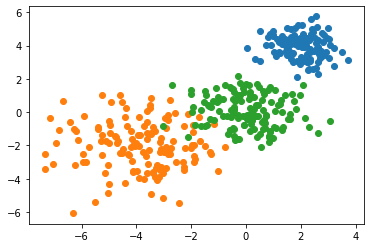

In [9]:
for k in np.unique(train_label_arg):
    train_ind = np.where(train_label_arg == k)[0]
    plt.scatter(train_X[train_ind,0], train_X[train_ind,1])

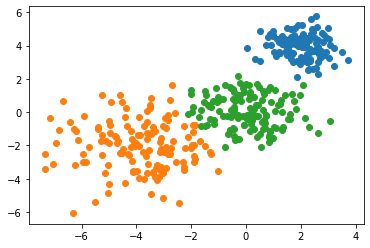

In [10]:
est_label_prob = gmm_diag_obj.result_["u_xi"]
est_label_arg = np.argmax(est_label_prob, axis = 1)

### 色をtrueと揃えるための処理
fitted_est_label_arg = np.zeros(len(est_label_arg))
fitted_est_label_arg[np.where(est_label_arg == 0)[0]] = 2
fitted_est_label_arg[np.where(est_label_arg == 2)[0]] = 0
fitted_est_label_arg[np.where(est_label_arg == 1)[0]] = 1

for k in np.unique(fitted_est_label_arg):
    train_ind = np.where(fitted_est_label_arg == k)[0]
    plt.scatter(train_X[train_ind,0], train_X[train_ind,1])
plt.show()

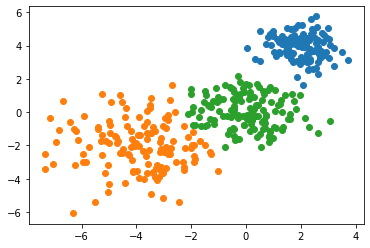

In [11]:
est_label_prob = hsmm_obj.result_["u_xi"]
est_label_arg = np.argmax(est_label_prob, axis = 1)

### 色をtrueと揃えるための処理
fitted_est_label_arg = est_label_arg.copy()
fitted_est_label_arg[np.where(est_label_arg == 0)[0]] = 2
fitted_est_label_arg[np.where(est_label_arg == 2)[0]] = 0
fitted_est_label_arg[np.where(est_label_arg == 3)[0]] = 1

for k in np.unique(fitted_est_label_arg):
    train_ind = np.where(fitted_est_label_arg == k)[0]
    plt.scatter(train_X[train_ind,0], train_X[train_ind,1])
plt.show()

# コンポーネントの分布が双曲線正割分布の場合

In [23]:
gerror_gmm_diag = np.zeros(len(data_seeds))
cklerror_gmm_diag = np.zeros(len(data_seeds))
c01error_gmm_diag = np.zeros(len(data_seeds))

gerror_gmm_cov = np.zeros(len(data_seeds))
cklerror_gmm_cov = np.zeros(len(data_seeds))
c01error_gmm_cov = np.zeros(len(data_seeds))

gerror_hsmm = np.zeros(len(data_seeds))
cklerror_hsmm = np.zeros(len(data_seeds))
c01error_hsmm = np.zeros(len(data_seeds))
for i, data_seed in enumerate(data_seeds):
    ### データを生成する
    (train_X, train_label, train_label_arg) = HyperbolicSecantMixtureModel.rvs(true_ratio, true_b, true_s, size = n, data_seed = data_seed)
    (test_X, test_label, test_label_arg) = HyperbolicSecantMixtureModel.rvs(true_ratio, true_b, true_s, size = N)
    
    gmm_diag_obj = GaussianMixtureModelVB(K = K[0],
                                     pri_alpha = pri_params["pri_alpha"], pri_beta = pri_params["pri_beta"], pri_gamma = pri_params["pri_gamma"], pri_delta = pri_params["pri_delta"], 
                                     iteration = 1000, restart_num=learning_num, learning_seed=data_seed + learning_seed_offset, method = "diag")
    gmm_diag_obj.fit(train_X)
    
    gmm_cov_obj = GaussianMixtureModelVB(K = K[0],
                                     pri_alpha = pri_params["pri_alpha"], pri_beta = pri_params["pri_beta"], pri_gamma = pri_params["pri_gamma"], pri_delta = pri_params["pri_delta"], 
                                     iteration = 1000, restart_num=learning_num, learning_seed=data_seed + learning_seed_offset, method = "full")
    gmm_cov_obj.fit(train_X)
    
    hsmm_obj = HyperbolicSecantMixtureVB(K = K[0],                                     
                                         pri_alpha = pri_params["pri_alpha"], pri_beta = pri_params["pri_beta"], pri_gamma = pri_params["pri_gamma"], pri_delta = pri_params["pri_delta"], 
                                         iteration = 1000, restart_num=learning_num, learning_seed=data_seed + learning_seed_offset)
    hsmm_obj.fit(train_X)
    
    posterior_true_logprob = HyperbolicSecantMixtureModel().latent_posterior_logprob(train_X, true_ratio, true_b, true_s)
    cklerror_gmm_diag[i] = gmm_diag_obj.score_latent_kl(posterior_true_logprob)[0]/len(train_X)
    cklerror_gmm_cov[i] = gmm_cov_obj.score_latent_kl(posterior_true_logprob)[0]/len(train_X)
    cklerror_hsmm[i] = hsmm_obj.score_latent_kl(posterior_true_logprob)[0]/len(train_X)
    
    c01error_gmm_diag[i] = gmm_diag_obj.score_clustering(train_label_arg)[0]/len(train_X)
    c01error_gmm_cov[i] = gmm_cov_obj.score_clustering(train_label_arg)[0]/len(train_X)
    c01error_hsmm[i] = hsmm_obj.score_clustering(train_label_arg)[0]/len(train_X)
    
    true_empirical_entropy = -HyperbolicSecantMixtureModel.logpdf(test_X, true_ratio, true_b, true_s)
    gerror_gmm_diag[i] = (-true_empirical_entropy - gmm_diag_obj.predict_logproba(test_X))/len(test_X)
    gerror_gmm_cov[i] = (-true_empirical_entropy - gmm_cov_obj.predict_logproba(test_X))/len(test_X)
    gerror_hsmm[i] = (-true_empirical_entropy - hsmm_obj.predict_logproba(test_X))/len(test_X)

In [24]:
print(f"""
gerror_gmm_diag: {gerror_gmm_diag.mean()},
gerror_gmm_cov: {gerror_gmm_cov.mean()},
gerror_hsmm: {gerror_hsmm.mean()},
cklerror_gmm_diag: {cklerror_gmm_diag.mean()},
cklerror_gmm_cov: {cklerror_gmm_cov.mean()},
cklerror_hsmm: {cklerror_hsmm.mean()},
c01error_gmm_diag: {c01error_gmm_diag.mean()},
c01error_gmm_cov: {c01error_gmm_cov.mean()},
c01error_hsmm: {c01error_hsmm.mean()}
""")


gerror_gmm_diag: -0.6045062702891912,
gerror_gmm_cov: -0.600146172265723,
gerror_hsmm: -0.645334544791902,
cklerror_gmm_diag: 5.468274477807025,
cklerror_gmm_cov: 5.764468394272928,
cklerror_hsmm: 0.9209644359514968,
c01error_gmm_diag: 0.85165,
c01error_gmm_cov: 0.8230500000000001,
c01error_hsmm: 0.8933500000000001



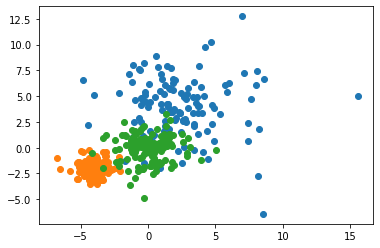

In [25]:
for k in np.unique(train_label_arg):
    train_ind = np.where(train_label_arg == k)[0]
    plt.scatter(train_X[train_ind,0], train_X[train_ind,1])

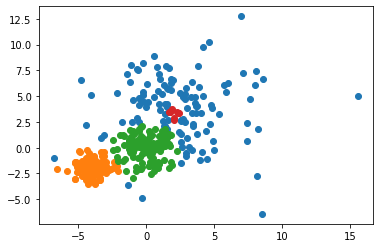

In [48]:
est_label_prob = gmm_diag_obj.result_["u_xi"]
est_label_arg = np.argmax(est_label_prob, axis = 1)

### 色をtrueと揃えるための処理
fitted_est_label_arg = np.zeros(len(est_label_arg))
fitted_est_label_arg[np.where(est_label_arg == 4)[0]] = 2
fitted_est_label_arg[np.where(est_label_arg == 2)[0]] = 0
fitted_est_label_arg[np.where(est_label_arg == 1)[0]] = 1
fitted_est_label_arg[np.where(est_label_arg == 3)[0]] = 3

for k in np.unique(fitted_est_label_arg):
    train_ind = np.where(fitted_est_label_arg == k)[0]
    plt.scatter(train_X[train_ind,0], train_X[train_ind,1])
plt.show()

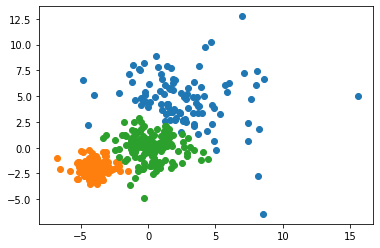

In [54]:
est_label_prob = hsmm_obj.result_["u_xi"]
est_label_arg = np.argmax(est_label_prob, axis = 1)

### 色をtrueと揃えるための処理
fitted_est_label_arg = est_label_arg.copy()
fitted_est_label_arg[np.where(est_label_arg == 0)[0]] = 0
fitted_est_label_arg[np.where(est_label_arg == 2)[0]] = 2
fitted_est_label_arg[np.where(est_label_arg == 4)[0]] = 1

for k in np.unique(fitted_est_label_arg):
    train_ind = np.where(fitted_est_label_arg == k)[0]
    plt.scatter(train_X[train_ind,0], train_X[train_ind,1])
plt.show()

# コンポーネントの分布がt分布の場合

In [55]:
gerror_gmm_diag = np.zeros(len(data_seeds))
cklerror_gmm_diag = np.zeros(len(data_seeds))
c01error_gmm_diag = np.zeros(len(data_seeds))

gerror_gmm_cov = np.zeros(len(data_seeds))
cklerror_gmm_cov = np.zeros(len(data_seeds))
c01error_gmm_cov = np.zeros(len(data_seeds))

gerror_hsmm = np.zeros(len(data_seeds))
cklerror_hsmm = np.zeros(len(data_seeds))
c01error_hsmm = np.zeros(len(data_seeds))

true_df = 3
for i, data_seed in enumerate(data_seeds):
    ### データを生成する
    (train_X, train_label, train_label_arg) = StudentMixtureModel.rvs(true_ratio, true_b, true_s, size = n, data_seed = data_seed, df = true_df)
    (test_X, test_label, test_label_arg) = StudentMixtureModel.rvs(true_ratio, true_b, true_s, size = N, df = true_df)
    
    gmm_diag_obj = GaussianMixtureModelVB(K = K[0],
                                     pri_alpha = pri_params["pri_alpha"], pri_beta = pri_params["pri_beta"], pri_gamma = pri_params["pri_gamma"], pri_delta = pri_params["pri_delta"], 
                                     iteration = 1000, restart_num=learning_num, learning_seed=data_seed + learning_seed_offset, method = "diag")
    gmm_diag_obj.fit(train_X)
    
    gmm_cov_obj = GaussianMixtureModelVB(K = K[0],
                                     pri_alpha = pri_params["pri_alpha"], pri_beta = pri_params["pri_beta"], pri_gamma = pri_params["pri_gamma"], pri_delta = pri_params["pri_delta"], 
                                     iteration = 1000, restart_num=learning_num, learning_seed=data_seed + learning_seed_offset, method = "full")
    gmm_cov_obj.fit(train_X)
    
    hsmm_obj = HyperbolicSecantMixtureVB(K = K[0],                                     
                                         pri_alpha = pri_params["pri_alpha"], pri_beta = pri_params["pri_beta"], pri_gamma = pri_params["pri_gamma"], pri_delta = pri_params["pri_delta"], 
                                         iteration = 1000, restart_num=learning_num, learning_seed=data_seed + learning_seed_offset)
    hsmm_obj.fit(train_X)
    
    posterior_true_logprob = StudentMixtureModel().latent_posterior_logprob(train_X, true_ratio, true_b, true_s, df = true_df)
    cklerror_gmm_diag[i] = gmm_diag_obj.score_latent_kl(posterior_true_logprob)[0]/len(train_X)
    cklerror_gmm_cov[i] = gmm_cov_obj.score_latent_kl(posterior_true_logprob)[0]/len(train_X)
    cklerror_hsmm[i] = hsmm_obj.score_latent_kl(posterior_true_logprob)[0]/len(train_X)
    
    c01error_gmm_diag[i] = gmm_diag_obj.score_clustering(train_label_arg)[0]/len(train_X)
    c01error_gmm_cov[i] = gmm_cov_obj.score_clustering(train_label_arg)[0]/len(train_X)
    c01error_hsmm[i] = hsmm_obj.score_clustering(train_label_arg)[0]/len(train_X)
    
    true_empirical_entropy = -StudentMixtureModel.logpdf(test_X, true_ratio, true_b, true_s, df = true_df)
    gerror_gmm_diag[i] = (-true_empirical_entropy - gmm_diag_obj.predict_logproba(test_X))/len(test_X)
    gerror_gmm_cov[i] = (-true_empirical_entropy - gmm_cov_obj.predict_logproba(test_X))/len(test_X)
    gerror_hsmm[i] = (-true_empirical_entropy - hsmm_obj.predict_logproba(test_X))/len(test_X)

In [56]:
print(f"""
gerror_gmm_diag: {gerror_gmm_diag.mean()},
gerror_gmm_cov: {gerror_gmm_cov.mean()},
gerror_hsmm: {gerror_hsmm.mean()},
cklerror_gmm_diag: {cklerror_gmm_diag.mean()},
cklerror_gmm_cov: {cklerror_gmm_cov.mean()},
cklerror_hsmm: {cklerror_hsmm.mean()},
c01error_gmm_diag: {c01error_gmm_diag.mean()},
c01error_gmm_cov: {c01error_gmm_cov.mean()},
c01error_hsmm: {c01error_hsmm.mean()}
""")


gerror_gmm_diag: 0.17984156410457883,
gerror_gmm_cov: 0.16078496025847946,
gerror_hsmm: 0.04867057924803943,
cklerror_gmm_diag: 1.168557703907011,
cklerror_gmm_cov: 1.3413629071166095,
cklerror_hsmm: 0.04758842712067483,
c01error_gmm_diag: 0.8177500000000001,
c01error_gmm_cov: 0.78405,
c01error_hsmm: 0.9067000000000001



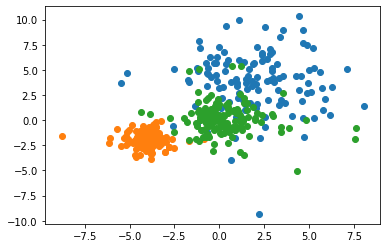

In [87]:
for k in np.unique(train_label_arg):
    train_ind = np.where(train_label_arg == k)[0]
    plt.scatter(train_X[train_ind,0], train_X[train_ind,1])

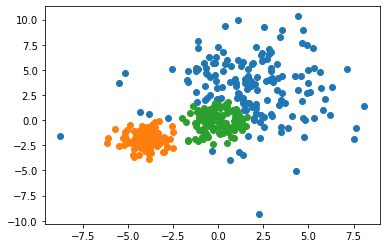

In [88]:
est_label_prob = gmm_diag_obj.result_["u_xi"]
est_label_arg = np.argmax(est_label_prob, axis = 1)

### 色をtrueと揃えるための処理
fitted_est_label_arg = np.zeros(len(est_label_arg))
fitted_est_label_arg[np.where(est_label_arg == 0)[0]] = 2
fitted_est_label_arg[np.where(est_label_arg == 3)[0]] = 0
fitted_est_label_arg[np.where(est_label_arg == 4)[0]] = 1

for k in np.unique(fitted_est_label_arg):
    train_ind = np.where(fitted_est_label_arg == k)[0]
    plt.scatter(train_X[train_ind,0], train_X[train_ind,1])
plt.show()

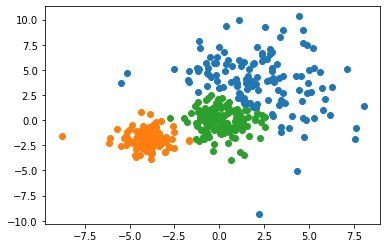

In [89]:
est_label_prob = hsmm_obj.result_["u_xi"]
est_label_arg = np.argmax(est_label_prob, axis = 1)

### 色をtrueと揃えるための処理
fitted_est_label_arg = est_label_arg.copy()
fitted_est_label_arg[np.where(est_label_arg == 0)[0]] = 0
fitted_est_label_arg[np.where(est_label_arg == 3)[0]] = 2
fitted_est_label_arg[np.where(est_label_arg == 4)[0]] = 1

for k in np.unique(fitted_est_label_arg):
    train_ind = np.where(fitted_est_label_arg == k)[0]
    plt.scatter(train_X[train_ind,0], train_X[train_ind,1])
plt.show()

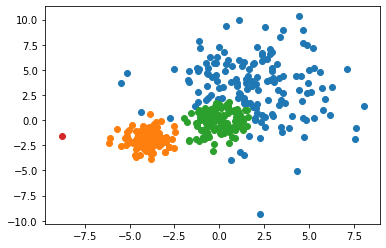

In [90]:
est_label_prob = gmm_cov_obj.result_["u_xi"]
est_label_arg = np.argmax(est_label_prob, axis = 1)

### 色をtrueと揃えるための処理
fitted_est_label_arg = est_label_arg.copy()
fitted_est_label_arg[np.where(est_label_arg == 1)[0]] = 0
fitted_est_label_arg[np.where(est_label_arg == 2)[0]] = 3
fitted_est_label_arg[np.where(est_label_arg == 3)[0]] = 1
fitted_est_label_arg[np.where(est_label_arg == 4)[0]] = 2

for k in np.unique(fitted_est_label_arg):
    train_ind = np.where(fitted_est_label_arg == k)[0]
    plt.scatter(train_X[train_ind,0], train_X[train_ind,1])
plt.show()

# コンポーネントの分布がラプラス分布の場合

In [91]:
gerror_gmm_diag = np.zeros(len(data_seeds))
cklerror_gmm_diag = np.zeros(len(data_seeds))
c01error_gmm_diag = np.zeros(len(data_seeds))

gerror_gmm_cov = np.zeros(len(data_seeds))
cklerror_gmm_cov = np.zeros(len(data_seeds))
c01error_gmm_cov = np.zeros(len(data_seeds))

gerror_hsmm = np.zeros(len(data_seeds))
cklerror_hsmm = np.zeros(len(data_seeds))
c01error_hsmm = np.zeros(len(data_seeds))

for i, data_seed in enumerate(data_seeds):
    ### データを生成する
    (train_X, train_label, train_label_arg) = LaplaceMixtureModel.rvs(true_ratio, true_b, true_s, size = n, data_seed = data_seed)
    (test_X, test_label, test_label_arg) = LaplaceMixtureModel.rvs(true_ratio, true_b, true_s, size = N)
    
    gmm_diag_obj = GaussianMixtureModelVB(K = K[0],
                                     pri_alpha = pri_params["pri_alpha"], pri_beta = pri_params["pri_beta"], pri_gamma = pri_params["pri_gamma"], pri_delta = pri_params["pri_delta"], 
                                     iteration = 1000, restart_num=learning_num, learning_seed=data_seed + learning_seed_offset, method = "diag")
    gmm_diag_obj.fit(train_X)
    
    gmm_cov_obj = GaussianMixtureModelVB(K = K[0],
                                     pri_alpha = pri_params["pri_alpha"], pri_beta = pri_params["pri_beta"], pri_gamma = pri_params["pri_gamma"], pri_delta = pri_params["pri_delta"], 
                                     iteration = 1000, restart_num=learning_num, learning_seed=data_seed + learning_seed_offset, method = "full")
    gmm_cov_obj.fit(train_X)
    
    hsmm_obj = HyperbolicSecantMixtureVB(K = K[0],                                     
                                         pri_alpha = pri_params["pri_alpha"], pri_beta = pri_params["pri_beta"], pri_gamma = pri_params["pri_gamma"], pri_delta = pri_params["pri_delta"], 
                                         iteration = 1000, restart_num=learning_num, learning_seed=data_seed + learning_seed_offset)
    hsmm_obj.fit(train_X)
    
    posterior_true_logprob = LaplaceMixtureModel().latent_posterior_logprob(train_X, true_ratio, true_b, true_s)
    cklerror_gmm_diag[i] = gmm_diag_obj.score_latent_kl(posterior_true_logprob)[0]/len(train_X)
    cklerror_gmm_cov[i] = gmm_cov_obj.score_latent_kl(posterior_true_logprob)[0]/len(train_X)
    cklerror_hsmm[i] = hsmm_obj.score_latent_kl(posterior_true_logprob)[0]/len(train_X)
    
    c01error_gmm_diag[i] = gmm_diag_obj.score_clustering(train_label_arg)[0]/len(train_X)
    c01error_gmm_cov[i] = gmm_cov_obj.score_clustering(train_label_arg)[0]/len(train_X)
    c01error_hsmm[i] = hsmm_obj.score_clustering(train_label_arg)[0]/len(train_X)
    
    true_empirical_entropy = -LaplaceMixtureModel.logpdf(test_X, true_ratio, true_b, true_s)
    gerror_gmm_diag[i] = (-true_empirical_entropy - gmm_diag_obj.predict_logproba(test_X))/len(test_X)
    gerror_gmm_cov[i] = (-true_empirical_entropy - gmm_cov_obj.predict_logproba(test_X))/len(test_X)
    gerror_hsmm[i] = (-true_empirical_entropy - hsmm_obj.predict_logproba(test_X))/len(test_X)

In [92]:
print(f"""
gerror_gmm_diag: {gerror_gmm_diag.mean()},
gerror_gmm_cov: {gerror_gmm_cov.mean()},
gerror_hsmm: {gerror_hsmm.mean()},
cklerror_gmm_diag: {cklerror_gmm_diag.mean()},
cklerror_gmm_cov: {cklerror_gmm_cov.mean()},
cklerror_hsmm: {cklerror_hsmm.mean()},
c01error_gmm_diag: {c01error_gmm_diag.mean()},
c01error_gmm_cov: {c01error_gmm_cov.mean()},
c01error_hsmm: {c01error_hsmm.mean()}
""")


gerror_gmm_diag: 0.10750980688289108,
gerror_gmm_cov: 0.10739847285574537,
gerror_hsmm: 0.04253613190151873,
cklerror_gmm_diag: 0.7187472120431455,
cklerror_gmm_cov: 0.9635010660320588,
cklerror_hsmm: 0.020684320264473484,
c01error_gmm_diag: 0.80905,
c01error_gmm_cov: 0.7776499999999998,
c01error_hsmm: 0.9178000000000002



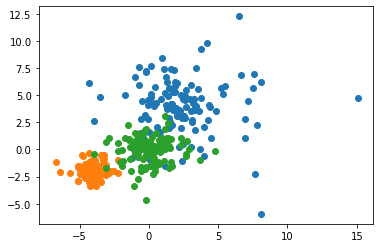

In [93]:
for k in np.unique(train_label_arg):
    train_ind = np.where(train_label_arg == k)[0]
    plt.scatter(train_X[train_ind,0], train_X[train_ind,1])

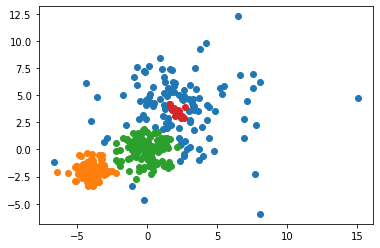

In [106]:
est_label_prob = gmm_diag_obj.result_["u_xi"]
est_label_arg = np.argmax(est_label_prob, axis = 1)

### 色をtrueと揃えるための処理
fitted_est_label_arg = np.zeros(len(est_label_arg))
fitted_est_label_arg[np.where(est_label_arg == 1)[0]] = 0
fitted_est_label_arg[np.where(est_label_arg == 2)[0]] = 1
fitted_est_label_arg[np.where(est_label_arg == 3)[0]] = 2
fitted_est_label_arg[np.where(est_label_arg == 4)[0]] = 3

for k in np.unique(fitted_est_label_arg):
    train_ind = np.where(fitted_est_label_arg == k)[0]
    plt.scatter(train_X[train_ind,0], train_X[train_ind,1])
plt.show()

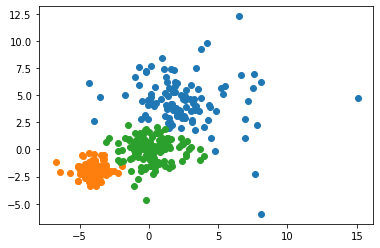

In [111]:
est_label_prob = hsmm_obj.result_["u_xi"]
est_label_arg = np.argmax(est_label_prob, axis = 1)

### 色をtrueと揃えるための処理
fitted_est_label_arg = est_label_arg.copy()
fitted_est_label_arg[np.where(est_label_arg == 1)[0]] = 2
fitted_est_label_arg[np.where(est_label_arg == 2)[0]] = 0
fitted_est_label_arg[np.where(est_label_arg == 4)[0]] = 1

for k in np.unique(fitted_est_label_arg):
    train_ind = np.where(fitted_est_label_arg == k)[0]
    plt.scatter(train_X[train_ind,0], train_X[train_ind,1])
plt.show()

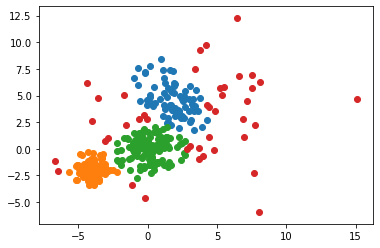

In [126]:
est_label_prob = gmm_cov_obj.result_["u_xi"]
est_label_arg = np.argmax(est_label_prob, axis = 1)

### 色をtrueと揃えるための処理
fitted_est_label_arg = est_label_arg.copy()
fitted_est_label_arg[np.where(est_label_arg == 0)[0]] = 2
fitted_est_label_arg[np.where(est_label_arg == 1)[0]] = 3
fitted_est_label_arg[np.where(est_label_arg == 3)[0]] = 0
fitted_est_label_arg[np.where(est_label_arg == 4)[0]] = 1

for k in np.unique(fitted_est_label_arg):
    train_ind = np.where(fitted_est_label_arg == k)[0]
    plt.scatter(train_X[train_ind,0], train_X[train_ind,1])
plt.show()

# コンポーネントの分布がガンベル分布の場合

In [127]:
gerror_gmm_diag = np.zeros(len(data_seeds))
cklerror_gmm_diag = np.zeros(len(data_seeds))
c01error_gmm_diag = np.zeros(len(data_seeds))

gerror_gmm_cov = np.zeros(len(data_seeds))
cklerror_gmm_cov = np.zeros(len(data_seeds))
c01error_gmm_cov = np.zeros(len(data_seeds))

gerror_hsmm = np.zeros(len(data_seeds))
cklerror_hsmm = np.zeros(len(data_seeds))
c01error_hsmm = np.zeros(len(data_seeds))

for i, data_seed in enumerate(data_seeds):
    ### データを生成する
    (train_X, train_label, train_label_arg) = GumbelMixtureModel.rvs(true_ratio, true_b, true_s, size = n, data_seed = data_seed)
    (test_X, test_label, test_label_arg) = GumbelMixtureModel.rvs(true_ratio, true_b, true_s, size = N)
    
    gmm_diag_obj = GaussianMixtureModelVB(K = K[0],
                                     pri_alpha = pri_params["pri_alpha"], pri_beta = pri_params["pri_beta"], pri_gamma = pri_params["pri_gamma"], pri_delta = pri_params["pri_delta"], 
                                     iteration = 1000, restart_num=learning_num, learning_seed=data_seed + learning_seed_offset, method = "diag")
    gmm_diag_obj.fit(train_X)
    
    gmm_cov_obj = GaussianMixtureModelVB(K = K[0],
                                     pri_alpha = pri_params["pri_alpha"], pri_beta = pri_params["pri_beta"], pri_gamma = pri_params["pri_gamma"], pri_delta = pri_params["pri_delta"], 
                                     iteration = 1000, restart_num=learning_num, learning_seed=data_seed + learning_seed_offset, method = "full")
    gmm_cov_obj.fit(train_X)
    
    hsmm_obj = HyperbolicSecantMixtureVB(K = K[0],                                     
                                         pri_alpha = pri_params["pri_alpha"], pri_beta = pri_params["pri_beta"], pri_gamma = pri_params["pri_gamma"], pri_delta = pri_params["pri_delta"], 
                                         iteration = 1000, restart_num=learning_num, learning_seed=data_seed + learning_seed_offset)
    hsmm_obj.fit(train_X)
    
    posterior_true_logprob = GumbelMixtureModel().latent_posterior_logprob(train_X, true_ratio, true_b, true_s)
    cklerror_gmm_diag[i] = gmm_diag_obj.score_latent_kl(posterior_true_logprob)[0]/len(train_X)
    cklerror_gmm_cov[i] = gmm_cov_obj.score_latent_kl(posterior_true_logprob)[0]/len(train_X)
    cklerror_hsmm[i] = hsmm_obj.score_latent_kl(posterior_true_logprob)[0]/len(train_X)
    
    c01error_gmm_diag[i] = gmm_diag_obj.score_clustering(train_label_arg)[0]/len(train_X)
    c01error_gmm_cov[i] = gmm_cov_obj.score_clustering(train_label_arg)[0]/len(train_X)
    c01error_hsmm[i] = hsmm_obj.score_clustering(train_label_arg)[0]/len(train_X)
    
    true_empirical_entropy = -GumbelMixtureModel.logpdf(test_X, true_ratio, true_b, true_s)
    gerror_gmm_diag[i] = (-true_empirical_entropy - gmm_diag_obj.predict_logproba(test_X))/len(test_X)
    gerror_gmm_cov[i] = (-true_empirical_entropy - gmm_cov_obj.predict_logproba(test_X))/len(test_X)
    gerror_hsmm[i] = (-true_empirical_entropy - hsmm_obj.predict_logproba(test_X))/len(test_X)

In [128]:
print(f"""
gerror_gmm_diag: {gerror_gmm_diag.mean()},
gerror_gmm_cov: {gerror_gmm_cov.mean()},
gerror_hsmm: {gerror_hsmm.mean()},
cklerror_gmm_diag: {cklerror_gmm_diag.mean()},
cklerror_gmm_cov: {cklerror_gmm_cov.mean()},
cklerror_hsmm: {cklerror_hsmm.mean()},
c01error_gmm_diag: {c01error_gmm_diag.mean()},
c01error_gmm_cov: {c01error_gmm_cov.mean()},
c01error_hsmm: {c01error_hsmm.mean()}
""")


gerror_gmm_diag: 0.12300595951150159,
gerror_gmm_cov: 0.1258183757125078,
gerror_hsmm: 0.12178722572644286,
cklerror_gmm_diag: 0.5648916827644413,
cklerror_gmm_cov: 0.7974884700487435,
cklerror_hsmm: 0.16794291808598177,
c01error_gmm_diag: 0.8296999999999999,
c01error_gmm_cov: 0.81625,
c01error_hsmm: 0.8878



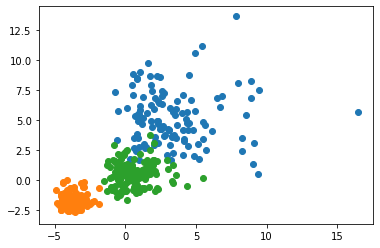

In [129]:
for k in np.unique(train_label_arg):
    train_ind = np.where(train_label_arg == k)[0]
    plt.scatter(train_X[train_ind,0], train_X[train_ind,1])

In [134]:
np.unique(est_label_arg)

array([0, 1, 2, 3, 4], dtype=int64)

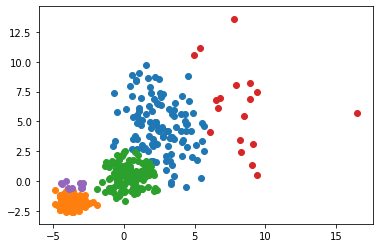

In [149]:
est_label_prob = gmm_diag_obj.result_["u_xi"]
est_label_arg = np.argmax(est_label_prob, axis = 1)

### 色をtrueと揃えるための処理
fitted_est_label_arg = np.zeros(len(est_label_arg))
fitted_est_label_arg[np.where(est_label_arg == 0)[0]] = 0
fitted_est_label_arg[np.where(est_label_arg == 1)[0]] = 3
fitted_est_label_arg[np.where(est_label_arg == 2)[0]] = 2
fitted_est_label_arg[np.where(est_label_arg == 3)[0]] = 1
fitted_est_label_arg[np.where(est_label_arg == 4)[0]] = 4

for k in np.unique(fitted_est_label_arg):
    train_ind = np.where(fitted_est_label_arg == k)[0]
    plt.scatter(train_X[train_ind,0], train_X[train_ind,1])
plt.show()

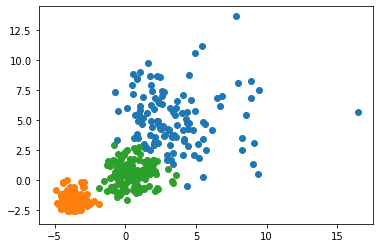

In [155]:
est_label_prob = hsmm_obj.result_["u_xi"]
est_label_arg = np.argmax(est_label_prob, axis = 1)

### 色をtrueと揃えるための処理
fitted_est_label_arg = est_label_arg.copy()
fitted_est_label_arg[np.where(est_label_arg == 0)[0]] = 1
fitted_est_label_arg[np.where(est_label_arg == 1)[0]] = 2
fitted_est_label_arg[np.where(est_label_arg == 3)[0]] = 0

for k in np.unique(fitted_est_label_arg):
    train_ind = np.where(fitted_est_label_arg == k)[0]
    plt.scatter(train_X[train_ind,0], train_X[train_ind,1])
plt.show()

In [157]:
np.unique(est_label_arg)

array([0, 1, 2, 3, 4], dtype=int64)

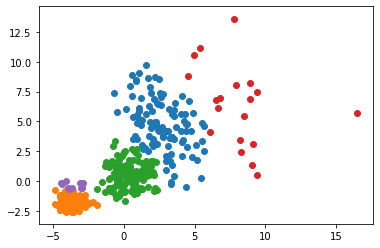

In [163]:
est_label_prob = gmm_cov_obj.result_["u_xi"]
est_label_arg = np.argmax(est_label_prob, axis = 1)

### 色をtrueと揃えるための処理
fitted_est_label_arg = est_label_arg.copy()
fitted_est_label_arg[np.where(est_label_arg == 0)[0]] = 3
fitted_est_label_arg[np.where(est_label_arg == 1)[0]] = 0
fitted_est_label_arg[np.where(est_label_arg == 2)[0]] = 2
fitted_est_label_arg[np.where(est_label_arg == 3)[0]] = 1
fitted_est_label_arg[np.where(est_label_arg == 4)[0]] = 4

for k in np.unique(fitted_est_label_arg):
    train_ind = np.where(fitted_est_label_arg == k)[0]
    plt.scatter(train_X[train_ind,0], train_X[train_ind,1])
plt.show()

# For real data
+ Fisher's iris data are used.
+ generalization loss and 01 loss are calculated here.

In [ ]:
skew(total_X)

In [ ]:
kurtosis(total_X)

In [ ]:
total_X.std(axis = 0)

In [ ]:
total_X.mean(axis = 0)

In [ ]:
for k in np.unique(train_label_arg):
    print(kurtosis(total_X[np.where(train_label_arg == k)[0],:]))

In [ ]:
# データを生成する
data = load_iris()
total_data = data.data
total_X = total_data**3
mean_val = total_data.mean(axis = 0)
std_val = total_data.std(axis = 0)
# total_X = ((total_data - mean_val)/std_val)**2

n = 150
N = total_X.shape[0] - n
shuffled_ind = np.random.permutation(n + N)
train_ind = shuffled_ind[:n]
test_ind = shuffled_ind[n:]

train_X = total_X[train_ind,:]
train_label_arg = data.target[train_ind]
test_X = total_X[test_ind,:]
test_label_arg = data.target[test_ind,]
n, M = train_X.shape

gmm_diag_obj = GaussianMixtureModelVB(K = K[0],
                                 pri_alpha = pri_params["pri_alpha"], pri_beta = pri_params["pri_beta"], pri_gamma = pri_params["pri_gamma"], pri_delta = pri_params["pri_delta"], 
                                 iteration = 1000, restart_num=learning_num, learning_seed=data_seed_start + learning_seed_offset, method = "diag")
gmm_diag_obj.fit(train_X)

gmm_cov_obj = GaussianMixtureModelVB(K = K[0],
                                 pri_alpha = pri_params["pri_alpha"], pri_beta = pri_params["pri_beta"], pri_gamma = M+2, pri_delta = pri_params["pri_delta"], 
                                 iteration = 1000, restart_num=learning_num, learning_seed=data_seed_start + learning_seed_offset, method = "full")
gmm_cov_obj.fit(train_X)

hsmm_obj = HyperbolicSecantMixtureVB(K = K[0],                                     
                                     pri_alpha = pri_params["pri_alpha"], pri_beta = pri_params["pri_beta"], pri_gamma = pri_params["pri_gamma"], pri_delta = pri_params["pri_delta"], 
                                     iteration = 1000, restart_num=learning_num, learning_seed=data_seed_start + learning_seed_offset)
hsmm_obj.fit(train_X)

c01error_gmm_diag = gmm_diag_obj.score_clustering(train_label_arg)[0]/len(train_X)
c01error_gmm_cov = gmm_cov_obj.score_clustering(train_label_arg)[0]/len(train_X)
c01error_hsmm = hsmm_obj.score_clustering(train_label_arg)[0]/len(train_X)

# gerror_gmm_diag = - gmm_diag_obj.predict_logproba(test_X)/len(test_X)
# gerror_gmm_cov=  - gmm_cov_obj.predict_logproba(test_X)/len(test_X)
# gerror_hsmm = - hsmm_obj.predict_logproba(test_X)/len(test_X)

In [ ]:
print(f"""
c01error_gmm_diag: {c01error_gmm_diag},
c01error_gmm_cov: {c01error_gmm_cov},
c01error_hsmm: {c01error_hsmm}
""")

# For real data
+ wine data are used.
+ generalization loss and 01 loss are calculated here.

In [ ]:
for k in np.unique(train_label_arg):
    print(kurtosis(total_X[np.where(train_label_arg == k)[0],:]))

In [ ]:
# データを生成する
data = load_wine()
total_data = data.data
mean_val = total_data.mean(axis = 0)
std_val = total_data.std(axis = 0)
total_X = (total_data - mean_val)/std_val
# total_X = total_X

n = 150
N = total_X.shape[0] - n
shuffled_ind = np.random.permutation(n + N)
train_ind = shuffled_ind[:n]
test_ind = shuffled_ind[n:]

train_X = total_X[train_ind,:]
train_label_arg = data.target[train_ind]
test_X = total_X[test_ind,:]
test_label_arg = data.target[test_ind,]
n, M = train_X.shape

gmm_diag_obj = GaussianMixtureModelVB(K = K[0],
                                 pri_alpha = pri_params["pri_alpha"], pri_beta = pri_params["pri_beta"], pri_gamma = pri_params["pri_gamma"], pri_delta = pri_params["pri_delta"], 
                                 iteration = 1000, restart_num=learning_num, learning_seed=data_seed_start + learning_seed_offset, method = "diag")
gmm_diag_obj.fit(train_X)

gmm_cov_obj = GaussianMixtureModelVB(K = K[0],
                                 pri_alpha = pri_params["pri_alpha"], pri_beta = pri_params["pri_beta"], pri_gamma = M+2, pri_delta = pri_params["pri_delta"], 
                                 iteration = 1000, restart_num=learning_num, learning_seed=data_seed_start + learning_seed_offset, method = "full")
gmm_cov_obj.fit(train_X)

hsmm_obj = HyperbolicSecantMixtureVB(K = K[0],                                     
                                     pri_alpha = pri_params["pri_alpha"], pri_beta = pri_params["pri_beta"], pri_gamma = pri_params["pri_gamma"], pri_delta = pri_params["pri_delta"], 
                                     iteration = 1000, restart_num=learning_num, learning_seed=data_seed_start + learning_seed_offset)
hsmm_obj.fit(train_X)

c01error_gmm_diag = gmm_diag_obj.score_clustering(train_label_arg)[0]/len(train_X)
c01error_gmm_cov = gmm_cov_obj.score_clustering(train_label_arg)[0]/len(train_X)
c01error_hsmm = hsmm_obj.score_clustering(train_label_arg)[0]/len(train_X)

gerror_gmm_diag = - gmm_diag_obj.predict_logproba(test_X)/len(test_X)
gerror_gmm_cov=  - gmm_cov_obj.predict_logproba(test_X)/len(test_X)
gerror_hsmm = - hsmm_obj.predict_logproba(test_X)/len(test_X)

In [ ]:
print(f"""
gerror_gmm_diag: {gerror_gmm_diag},
gerror_gmm_cov: {gerror_gmm_cov},
gerror_hsmm: {gerror_hsmm},
c01error_gmm_diag: {c01error_gmm_diag},
c01error_gmm_cov: {c01error_gmm_cov},
c01error_hsmm: {c01error_hsmm}
""")

# For real data
+ breast cancer data
+ generalization loss and 01 loss are calculated here.

In [ ]:
# データを生成する
data = load_breast_cancer()
total_data = data.data
total_X = total_data
mean_val = total_data.mean(axis = 0)
std_val = total_data.std(axis = 0)
total_X = (total_data - mean_val)/std_val

n = 400
N = total_X.shape[0] - n
shuffled_ind = np.random.permutation(n + N)
train_ind = shuffled_ind[:n]
test_ind = shuffled_ind[n:]

train_X = total_X[train_ind,:]
train_label_arg = data.target[train_ind]
test_X = total_X[test_ind,:]
test_label_arg = data.target[test_ind,]
n, M = train_X.shape

gmm_diag_obj = GaussianMixtureModelVB(K = K[1],
                                 pri_alpha = pri_params["pri_alpha"], pri_beta = pri_params["pri_beta"], pri_gamma = pri_params["pri_gamma"], pri_delta = pri_params["pri_delta"], 
                                 iteration = 1000, restart_num=learning_num, learning_seed=data_seed_start + learning_seed_offset, method = "diag")
gmm_diag_obj.fit(train_X)

gmm_cov_obj = GaussianMixtureModelVB(K = K[1],
                                 pri_alpha = pri_params["pri_alpha"], pri_beta = pri_params["pri_beta"], pri_gamma = M + 2, pri_delta = pri_params["pri_delta"], 
                                 iteration = 1000, restart_num=learning_num, learning_seed=data_seed_start + learning_seed_offset, method = "full")
gmm_cov_obj.fit(train_X)

hsmm_obj = HyperbolicSecantMixtureVB(K = K[1],                                     
                                     pri_alpha = pri_params["pri_alpha"], pri_beta = pri_params["pri_beta"], pri_gamma = pri_params["pri_gamma"], pri_delta = pri_params["pri_delta"], 
                                     iteration = 1000, restart_num=learning_num, learning_seed=data_seed_start + learning_seed_offset)
hsmm_obj.fit(train_X)

c01error_gmm_diag = gmm_diag_obj.score_clustering(train_label_arg)[0]/len(train_X)
c01error_gmm_cov = gmm_cov_obj.score_clustering(train_label_arg)[0]/len(train_X)
c01error_hsmm = hsmm_obj.score_clustering(train_label_arg)[0]/len(train_X)

gerror_gmm_diag = - gmm_diag_obj.predict_logproba(test_X)/len(test_X)
gerror_gmm_cov=  - gmm_cov_obj.predict_logproba(test_X)/len(test_X)
gerror_hsmm = - hsmm_obj.predict_logproba(test_X)/len(test_X)

In [ ]:
print(f"""
gerror_gmm_diag: {gerror_gmm_diag},
gerror_gmm_cov: {gerror_gmm_cov},
gerror_hsmm: {gerror_hsmm},
c01error_gmm_diag: {c01error_gmm_diag},
c01error_gmm_cov: {c01error_gmm_cov},
c01error_hsmm: {c01error_hsmm}
""")